# Importing Library

In [ ]:
## Import Libraries
#! pip install optuna
! pip install attention

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string

from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences

import logging
import sys

from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from attention import Attention
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
import optuna
from sklearn.model_selection import StratifiedKFold

from optuna.pruners import SuccessiveHalvingPruner
from optuna.samplers import TPESampler

from sklearn.metrics import f1_score,classification_report,confusion_matrix

import warnings
warnings.filterwarnings('ignore')

random = 14

# Import and Preprocess Datasets

1. Read `train.csv` and `test.csv` and combine them into one dataset `D`.
2. Force the target value into a binary value.
3. Perform Exploratory Data Analysis.
4. Perform text preprocessing: Lower Casing, Counting number of words etc.
5. Tokenizing and Padding Text Data.

In [4]:
## Dataset Paths
path = '../data/'
train_path = f'{path}train.csv'
test_path = f'{path}test.csv'
test_labels_path = f'{path}test_labels.csv'

In [ ]:
## Reading Datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
test_labels = pd.read_csv(test_labels_path)[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']]
test = pd.concat([test, test_labels],axis=1)
test = test.loc[test['toxic'] != -1] # Data having toxic of value -1 means they are not labelled. Therefore, removed.

D = pd.concat([train, test], axis=0)

## Exploratory Data Analysis

### Checking for Data Shape and Nulls Values

In [4]:
## Checking Null Entries
print("Number of Null Data: " + str(D.isnull().sum().sum()))

## Checking Dimensions
print("Number of Variables: ")
print(D.shape[1])
print("\nNumber of Data Points: ")
print(D.shape[0])

## Structure of the Dataset
D.head()

Number of Null Data: 0
Number of Variables: 
8

Number of Data Points: 
223549


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## Forcing Target Values to Binary Values

In [47]:
## Checks for Creating New Dependent Variable
def analyze_var(df, col_list):
    col_list_v = col_list[1:]
    res = pd.DataFrame(col_list_v)
    for dv in col_list_v:
        count = []
        D_dv = D.loc[D[dv]==1]
        for dv2 in col_list_v:
            D_dv_dv2 = D_dv.loc[D_dv[dv2]==1]
            count.append(D_dv_dv2.shape[0])
        res = pd.concat([res,pd.DataFrame(count)],axis=1)
    res.columns = col_list
    return res

analyze_var(D, ['var_count','toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate'])

,var_count,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,toxic,21384,1962,11552,654,10686,1995
1,severe_toxic,1962,1962,1880,158,1701,448
2,obscene,11552,1880,12140,439,8884,1570
3,threat,654,158,439,689,445,145
4,insult,10686,1701,8884,445,11304,1762
5,identity_hate,1995,448,1570,145,1762,2117


In [6]:
## Create New Dependent Variable - Malignant
def force_one(x):
    if x > 1:
        return 1
    else:
        return x

D['malignant'] = D['toxic'] + D['obscene'] + D['threat'] + D['insult'] + D['identity_hate']
D['malignant'] = D['malignant'].apply(lambda x: force_one(x))
D = D[['id','comment_text','malignant']]

D.head()

,id,comment_text,malignant
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0


### Distribution of Target Variable

Note: The dataset is greatly unbalanced.

Number of Non-Malignant Comments: 201081
Number of Malignant Comments: 22468


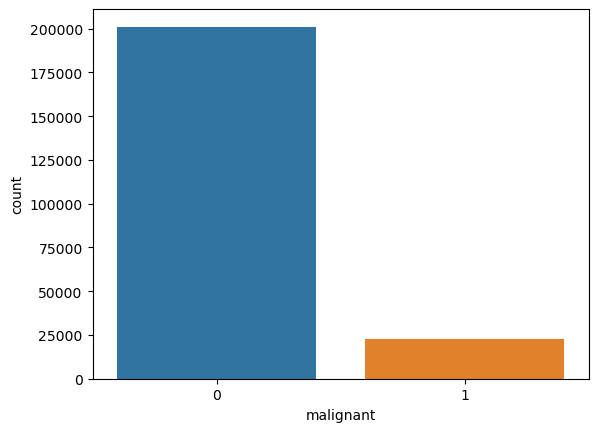

In [50]:
## Distribution of Dependent Variable - Malignant
sns.countplot(data = D, x= 'malignant')
print("Number of Non-Malignant Comments: {0}".format(sum(D['malignant'] == 0)))
print("Number of Malignant Comments: {0}".format(sum(D['malignant'] == 1)))

## Preprocessing and Feature Extraction

Puncuations that are found to express emotions in chats are counted separately once again. Those punctuations are chosen from the sources below:

1. "The interactional principle in digital punctuation": https://www.sciencedirect.com/science/article/pii/S2211695821000180
2. "Punctuation is the New Measure of Emotion": https://ericadhawan.medium.com/punctuation-is-the-new-measure-of-emotion-329b684743f0

In [7]:
## Text Feature Extraction - D

#### Make Strings to Lower Case
D['comment_text'] = D['comment_text'].str.lower()

#### Keep Track of String's Original Length
D['length'] = D['comment_text'].str.len()

#### Replace Email Address with 'email'
D['comment_text'] = D['comment_text'].str.replace(r'^.+@[^\.].*\.[a-z]{2,}$','email')

#### Replace Website Address with 'website'
D['comment_text'] = D['comment_text'].str.replace(r'^http[s]{0,1}\://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$','website')

#### Replace Website Address with 'phonenumber'
D['comment_text'] = D['comment_text'].str.replace(r'^\(?[\d]{3}\)?[\s-]?[\d]{3}[\s-]?[\d]{4}$','phonenumber') # Note, might contain a random 10 digit number.

#### Replace Numbers with 'numbrs'
D['comment_text'] = D['comment_text'].str.replace(r'\d+(\.\d+)?', 'numbr')

#### Special Punctuations are Replaced Explicitly.
D['comment_text'] = D['comment_text'].str.replace(r'!',' exclamationmark')
D['comment_text'] = D['comment_text'].str.replace(r'\?',' questionmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{1}',' periodmark')
D['comment_text'] = D['comment_text'].str.replace(r'\.{2,}',' ellipsismark')
D['comment_text'] = D['comment_text'].str.replace(r'£|\$', ' dollers')

## Removing Leftover Punctuations
def remove_punct(text):
    p_free="".join([i for i in text if i not in string.punctuation])
    return p_free
D['comment_text'] = D['comment_text'].apply(lambda x:remove_punct(x))

In [8]:
## Tokenizing Strings
X = D['comment_text']
y = D['malignant']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random)

train_text = X_train.fillna("_na_").values
test_text = X_test.fillna("_na_").values

max_features = 20000

tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(train_text))
tokenized_train = tokenizer.texts_to_sequences(train_text)
tokenized_test = tokenizer.texts_to_sequences(test_text)

In [53]:
print("Number of observations in X_train: {}".format(X_train.shape[0]))
print("Number of observations in X_test: {}".format(X_test.shape[0]))

Number of observations in X_train: 156484
Number of observations in X_test: 67065


#### Brief Exploration to Tokenized Dataset

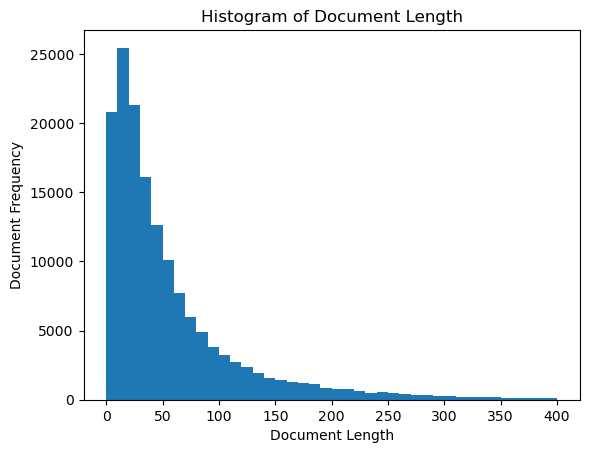

In [56]:
## Distribution of Number of Words.
totalNumWords = [len(text) for text in tokenized_train]
plt.hist(totalNumWords,bins = np.arange(0,410,10))
plt.title('Histogram of Document Length')
plt.ylabel('Document Frequency')
plt.xlabel('Document Length')
plt.show()

In [9]:
## Pad the Tokenized List - Evening Length
maxlen = 150
X_train = pad_sequences(tokenized_train, maxlen=maxlen)
X_test = pad_sequences(tokenized_test, maxlen=maxlen)

## Building and Training Model - LSTM on Original/Unbalanced Dataset

In [ ]:
def build_lstm(hp, maxlen, max_features, X, y):
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, hp['embed_size'])(inp)
    x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
    if hp['attention'] == 1:
        x = Attention(units=hp['attention_units'])(x)
    else:
        x = GlobalMaxPool1D()(x)
    x = Dense(50, activation='relu')(x)
    x = Dropout(hp['dropout'])(x)
    x = Dense(1, activation="sigmoid")(x)
    model = Model(inputs=inp, outputs=x)
    model.compile(loss='binary_crossentropy', 
                  optimizer=optimizers.Adam(), 
                  metrics=['accuracy'])
    X_t, X_v, y_t, y_v = train_test_split(X, y, test_size=0.5, random_state=random)
    model.fit(X_t, y_t, epochs=hp['epochs'], batch_size=hp['batch_size'])
    y_pred = model.predict([X_v], batch_size=256, verbose=1)
    y_pred = (y_pred > 0.5).astype(int)
    score = f1_score(y_v, y_pred, average = 'macro')
    return model, score#np.mean(scores)

def build_lstm_cv(hp, maxlen, max_features, X, y, cv):
    scores = []
    skf = StratifiedKFold(n_splits=cv)
    for i, (train_index, test_index) in enumerate(skf.split(X,y)):
        inp = Input(shape=(maxlen, ))
        x = Embedding(max_features, hp['embed_size'])(inp)
        if hp['bidirectional'] == 1:
            x = Bidirectional(LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0))(x)
        else:
            x = LSTM(hp['op_lstm_size'], return_sequences=True, dropout=hp['dropout_lstm'], recurrent_dropout=0)(x)
        if hp['attention'] == 1:
            x = Attention(units=hp['attention_units'])(x)
        else:
            x = GlobalMaxPool1D()(x)
        x = Dense(50, activation='relu')(x)
        x = Dropout(hp['dropout'])(x)
        x = Dense(1, activation="sigmoid")(x)
        model = Model(inputs=inp, outputs=x)
        model.compile(loss='binary_crossentropy', 
                      optimizer=optimizers.Adam(), 
                      metrics=['accuracy'])
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_true = y[test_index]
        model.fit(X_train, y_train, epochs=hp['epochs'], batch_size=hp['batch_size'])
        gc.collect()
        y_pred = model.predict([X_test], batch_size=256, verbose=1)
        y_pred = (y_pred > 0.5).astype(int)
        scores.append(f1_score(y_true, y_pred, average = 'macro'))
        gc.collect()
        # You can add something here if you want to keep track of cv scores independently.
    return model, np.mean(scores)
        
def objective(trial, maxlen, max_features, X, y, cv, apply_cv = False):
    hp = {
        'embed_size': trial.suggest_int('embed_size', 64, 256, step = 64),
        'op_lstm_size': trial.suggest_int('op_lstm_size', 50, 60),
        'dropout_lstm': trial.suggest_float('dropout_lstm', 0, 0.5),
        'dropout': trial.suggest_float('dropout', 0, 0.5),
        'epochs': trial.suggest_int('epochs', 2, 5),
        'batch_size': trial.suggest_categorical('batch_size', [128,256,512,1024]),
        'attention': trial.suggest_categorical('attention', [0,1]),
        'attention_units': trial.suggest_categorical('attention_units', [16,32,64]),
        'bidirectional': trial.suggest_categorical('bidirectional', [0,1])
    }
    
    model, f1macro = build_lstm(hp, maxlen, max_features, X, y)

    return f1macro

In [ ]:
#optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
#study_name = "cs3244-lstm-study-f1_macro" 
#storage_name = "sqlite:///{}.db".format(study_name)

In [ ]:
#import os
#os.system('rm /kaggle/working/cs3244-lstm-study-f1_macro.csv')
#os.system('cp /kaggle/input/cs3244-lstm/cs3244-lstm-study.db /kaggle/working/cs3244-lstm-study.db')

In [ ]:
#cv = 5
#study = optuna.create_study(direction="maximize", sampler=TPESampler(), pruner=SuccessiveHalvingPruner(),
#                            study_name=study_name, storage=storage_name, load_if_exists=True)
#func = lambda trial: objective(trial, maxlen, max_features, X_train, y_train, cv, apply_cv = False)
#study.optimize(func, n_trials=1, gc_after_trial=True)

In [ ]:
#study.trials_dataframe().to_csv("/kaggle/working/cs3244-lstm-study-f1_macro.csv")
#study.trials_dataframe()

In [10]:
## Loading Saved Outputs
original_res_path = f'{path}original_data_tuning.csv'
original_res = pd.read_csv(original_res_path)[['value', 'params_attention', 'params_attention_units', 'params_batch_size', 
                                               'params_bidirectional', 'params_dropout', 'params_dropout_lstm', 'params_embed_size', 
                                               'params_epochs', 'params_op_lstm_size']]

In [11]:
## Best Parameter for LSTM
best_param = original_res[original_res['value'] == np.max(original_res['value'])].reset_index()
best_param.columns = ['index', 'value', 'attention', 'attention_units', 
                      'batch_size', 'bidirectional', 'dropout', 'dropout_lstm', 
                      'embed_size', 'epochs', 'op_lstm_size']

The resulting best parameters for LSTM model trained on original dataset is:
* Attention: No Attention used.
* batch_size: 256
* bidirectional: bidirectional LSTM was used.
* dropout: 0.32709
* dropout_lstm: 0.33699
* embed_size = 128
* epochs = 2
* op_lstm_size = 52
* threshold_value = 0.45

The Final Test Score on Test Set is:
* Accuracy: 0.96
* F1-Macro Score: 0.8685

In [13]:
## Finding Optimal Threshold
#cv = 10
#skf = StratifiedKFold(n_splits=cv)
#output = []
#indices = []
#for i, (train_index, test_index) in enumerate(skf.split(X_train,y_train)):
#    indices.append([train_index, test_index])
## Storing CV split index. Run in separate runtimes.
#X_train_idx = []
#X_val_idx = []
#for i in [0,1,2,3,4,5,6,7,8,9]:
#    X_train_idx.append(indices[i][0])
#    X_val_idx.append(indices[i][1])
#X_train_idx = pd.DataFrame(X_train_idx)
#X_val_idx = pd.DataFrame(X_val_idx)
#X_train_idx.to_csv("/kaggle/working/X_train_idx.csv")
#X_val_idx.to_csv("/kaggle/working/X_val_idx.csv")

In [22]:
train_idx_path = f'{path}X_train_idx.csv'
val_idx_path = f'{path}X_val_idx.csv'
X_train_idx = pd.read_csv(train_idx_path)
X_val_idx = pd.read_csv(val_idx_path)

In [23]:
scores = []

In [33]:
cv_idx = 9
train_index = np.array(X_train_idx[X_train_idx['Unnamed: 0']==cv_idx])[0][1:len(np.array(X_train_idx[X_train_idx['Unnamed: 0']==0])[0])-2].astype('int')
test_index = np.array(X_val_idx[X_val_idx['Unnamed: 0']==cv_idx])[0][1:len(np.array(X_val_idx[X_val_idx['Unnamed: 0']==0])[0])-2].astype('int')
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, 128)(inp)
x = Bidirectional(LSTM(52, return_sequences=True, dropout=0.333699, recurrent_dropout=0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.32709)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])
X_t = X_train[train_index]
y_t = y_train.iloc[train_index]
X_v = X_train[test_index]
y_v = y_train.iloc[test_index]
model.fit(X_t, y_t, epochs=2, batch_size=256)
y_pred = model.predict([X_v], batch_size=256, verbose=1)
score = []
for thresh in np.arange(0,1.01,0.05):
    y_thresh = (y_pred > thresh).astype(int)
    score.append(f1_score(y_v, y_thresh, average = 'macro'))
scores.append(score)

Epoch 1/2
551/551 [==============================] - 18s 26ms/step - loss: 0.1896 - accuracy: 0.9346
Epoch 2/2
62/62 [==============================] - 1s 10ms/step


In [34]:
#pd.DataFrame(scores).to_csv("/kaggle/working/threshold_scores_original.csv")

In [36]:
threshold_path = f'{path}threshold_scores_original.csv'
threshold_scores = pd.read_csv(threshold_path)
scores = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    score = np.array((threshold_scores[threshold_scores['Unnamed: 0']==i]))[0][1:22]
    scores.append(score)
avg_score = (np.array(scores[0]) + np.array(scores[1]) + np.array(scores[2]) + np.array(scores[3]) + np.array(scores[4]) + np.array(scores[5]) + np.array(scores[6]) + np.array(scores[7]) + np.array(scores[8]) + np.array(scores[9]))/10
best_threshold = np.arange(0,1.01,0.05)[avg_score == np.max(avg_score)][0]

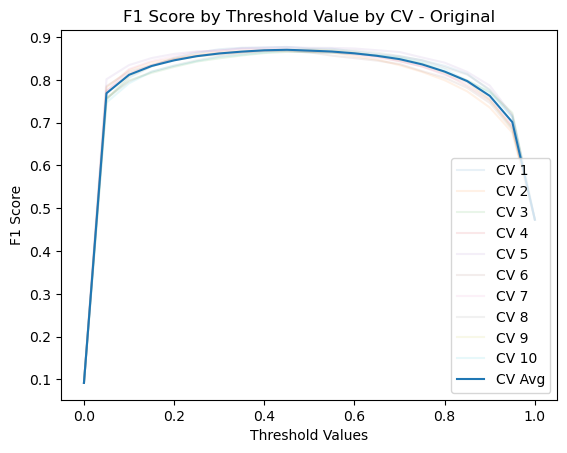

In [42]:
## F1 Macro Scores by Threshold
thresholds = np.arange(0,1.01,0.05)
plt.plot(thresholds,scores[0], alpha=0.1)
plt.plot(thresholds,scores[1], alpha=0.1)
plt.plot(thresholds,scores[2], alpha=0.1)
plt.plot(thresholds,scores[3], alpha=0.1)
plt.plot(thresholds,scores[4], alpha=0.1)
plt.plot(thresholds,scores[5], alpha=0.1)
plt.plot(thresholds,scores[6], alpha=0.1)
plt.plot(thresholds,scores[7], alpha=0.1)
plt.plot(thresholds,scores[8], alpha=0.1)
plt.plot(thresholds,scores[9], alpha=0.1)
plt.plot(thresholds,avg_score)
plt.title('F1 Score by Threshold Value by CV - Original')
plt.ylabel('F1 Score')
plt.xlabel('Threshold Values')
plt.legend(['CV 1', 'CV 2','CV 3','CV 4', 'CV 5', 'CV 6', 'CV 7', 'CV 8', 'CV 9', 'CV 10', 'CV Avg'], loc='lower right')
plt.show()

In [45]:
## LSTM CI from CV Results
cv_f1_score_lstm = []
for i in [0,1,2,3,4,5,6,7,8,9]:
    f1_cv = scores[i][np.arange(0,1.01,0.05)==best_threshold]
    cv_f1_score_lstm.append(f1_cv[0])
lstm_mean = np.mean(cv_f1_score_lstm)
lstm_std = np.std(cv_f1_score_lstm)
lstm_ci = [lstm_mean - 3*lstm_std, lstm_mean + 3*lstm_std] ## Includes 99.7% numbers around est. mean.

In [46]:
print("Mean CV Score: {}".format(lstm_mean))
print("Standard Deviation CV Score: {}".format(lstm_std))
print("99.7% Confidence Interval: {}".format(lstm_ci))

Mean CV Score: 0.8702824188741103
Standard Deviation CV Score: 0.0036274724586236057


In [48]:
## Final Test on Test Data
inp = Input(shape=(maxlen, ))
x = Embedding(max_features, 128)(inp)
x = Bidirectional(LSTM(52, return_sequences=True, dropout=0.333699, recurrent_dropout=0))(x)
x = GlobalMaxPool1D()(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.32709)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.Adam(), 
              metrics=['accuracy'])
model.fit(X_train, y_train, epochs=2, batch_size=256)
y_pred = model.predict([X_test], batch_size=256, verbose=1)
y_pred = (y_pred > best_threshold).astype(int)
print('[LSTM] F1 Macro score is {}'.format(f1_score(y_test, y_pred, average = 'macro')))
print(confusion_matrix(y_test,y_pred))
print(classification_report(y_test,y_pred))

Epoch 1/2
612/612 [==============================] - 19s 26ms/step - loss: 0.1809 - accuracy: 0.9359
Epoch 2/2
262/262 [==============================] - 3s 8ms/step
[LSTM] F1 Macro score is 0.8685497068319775
[[59254  1175]
 [ 1830  4806]]
              precision    recall  f1-score   support

           0       0.97      0.98      0.98     60429
           1       0.80      0.72      0.76      6636

    accuracy                           0.96     67065
   macro avg       0.89      0.85      0.87     67065
weighted avg       0.95      0.96      0.95     67065

